## Difference-in-Differences Estimation

`PyFixest` supports eventy study designs via the canonical two-way fixed effects design Gardner's 2-stage estimator, and the local projections approach following [Dube et al (2023)](https://www.nber.org/papers/w31184).

In [70]:
import pandas as pd

import pyfixest as pf
from pyfixest.did.estimation import did2s, lpdid
from pyfixest.did.visualize import panelview
from pyfixest.report.utils import rename_event_study_coefs

%load_ext watermark
%watermark --iversions

pyfixest: 0.24.0
pandas  : 2.2.2



In [71]:
url = "https://raw.githubusercontent.com/py-econometrics/pyfixest/master/pyfixest/did/data/df_het.csv"
df_het = pd.read_csv(url)
df_het.head()

,unit,state,group,unit_fe,g,year,year_fe,treat,rel_year,rel_year_binned,error,te,te_dynamic,dep_var
0,1,33,Group 2,7.043016,2010,1990,0.066159,False,-20.0,-6,-0.086466,0,0.0,7.022709
1,1,33,Group 2,7.043016,2010,1991,-0.030980,False,-19.0,-6,0.766593,0,0.0,7.778628
2,1,33,Group 2,7.043016,2010,1992,-0.119607,False,-18.0,-6,1.512968,0,0.0,8.436377
3,1,33,Group 2,7.043016,2010,1993,0.126321,False,-17.0,-6,0.021870,0,0.0,7.191207
4,1,33,Group 2,7.043016,2010,1994,-0.106921,False,-16.0,-6,-0.017603,0,0.0,6.918492


### Examining Treatment Timing

Before any DiD estimation, we need to examine the treatment timing, since it is crucial to our choice of estimator. 

<Axes: title={'center': 'Treatment Assignment Cohorts'}, xlabel='Year', ylabel='Cohort'>

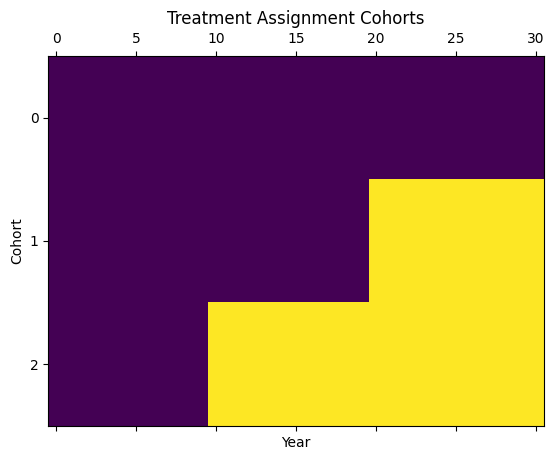

In [72]:
panelview(
    df_het,
    unit="unit", time="year", treat="treat",
    collapse_to_cohort=True,
    sort_by_timing=True,
    ylab="Cohort", xlab="Year",
    title = "Treatment Assignment Cohorts",
)

We immediately see that we have staggered adoption of treatment, which implies that a naive application of 2WFE might yield biased estimates under substantial effect heterogeneity.

We can also plot treatment assignment in a disaggregated fashion, which gives us a sense of cohort sizes.

<Axes: title={'center': 'Treatment Assignment (all units)'}, xlabel='Year', ylabel='Unit'>

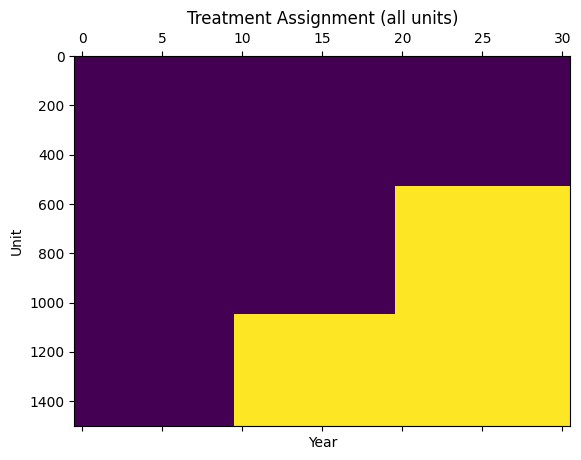

In [73]:
panelview(
    df_het,
    unit="unit", time="year", treat="treat",
    sort_by_timing=True,
    ylab="Unit", xlab="Year",
    title = "Treatment Assignment (all units)",
)

### Inspect the Outcome Variables

We can create time-series plots of the raw outcome by specifying `type = "outcome"`.

<Axes: title={'center': 'Outcome Values and Treatment Assignments'}, xlabel='Year', ylabel='Outcome'>

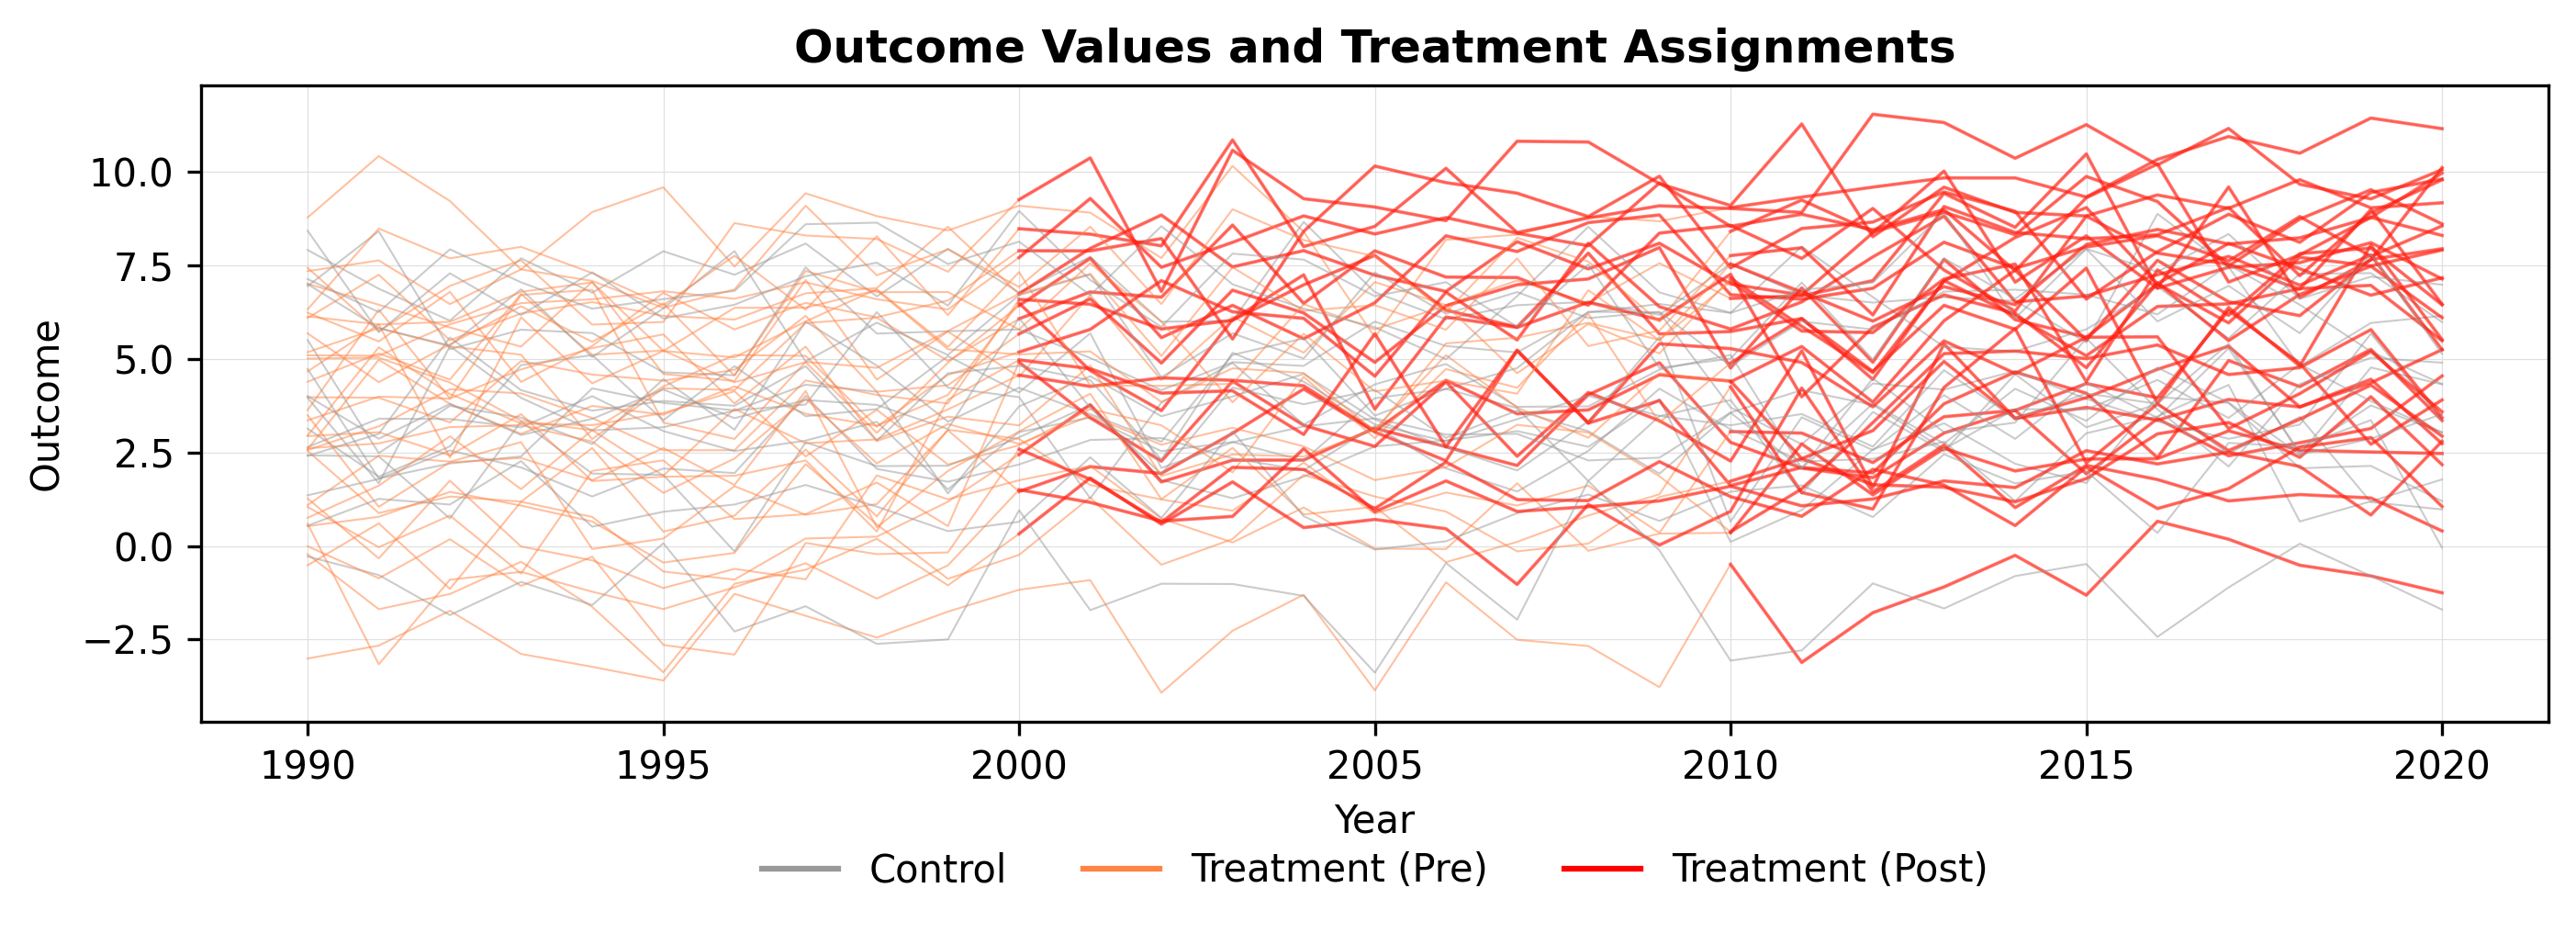

In [74]:
panelview(
    df_het,
    type = "outcome",
    outcome = "dep_var",
    unit="unit",
    time="year",
    treat="treat",
    ylab="Outcome",
    xlab="Year",
    title = "Outcome Values and Treatment Assignments",
    subsamp = 50,
    legend = True
)

Users also have the option to enable `collapse_to_cohort = True` in outcome plot to visualize the average outcome trajectories of units that share the same treatment history. By using this feature, the plot will group units based on their treatment timeline, allowing for a clearer comparison of how different cohorts respond over time.

<Axes: title={'center': 'Outcome Values and Treatment Assignments'}, xlabel='Year', ylabel='Outcome'>

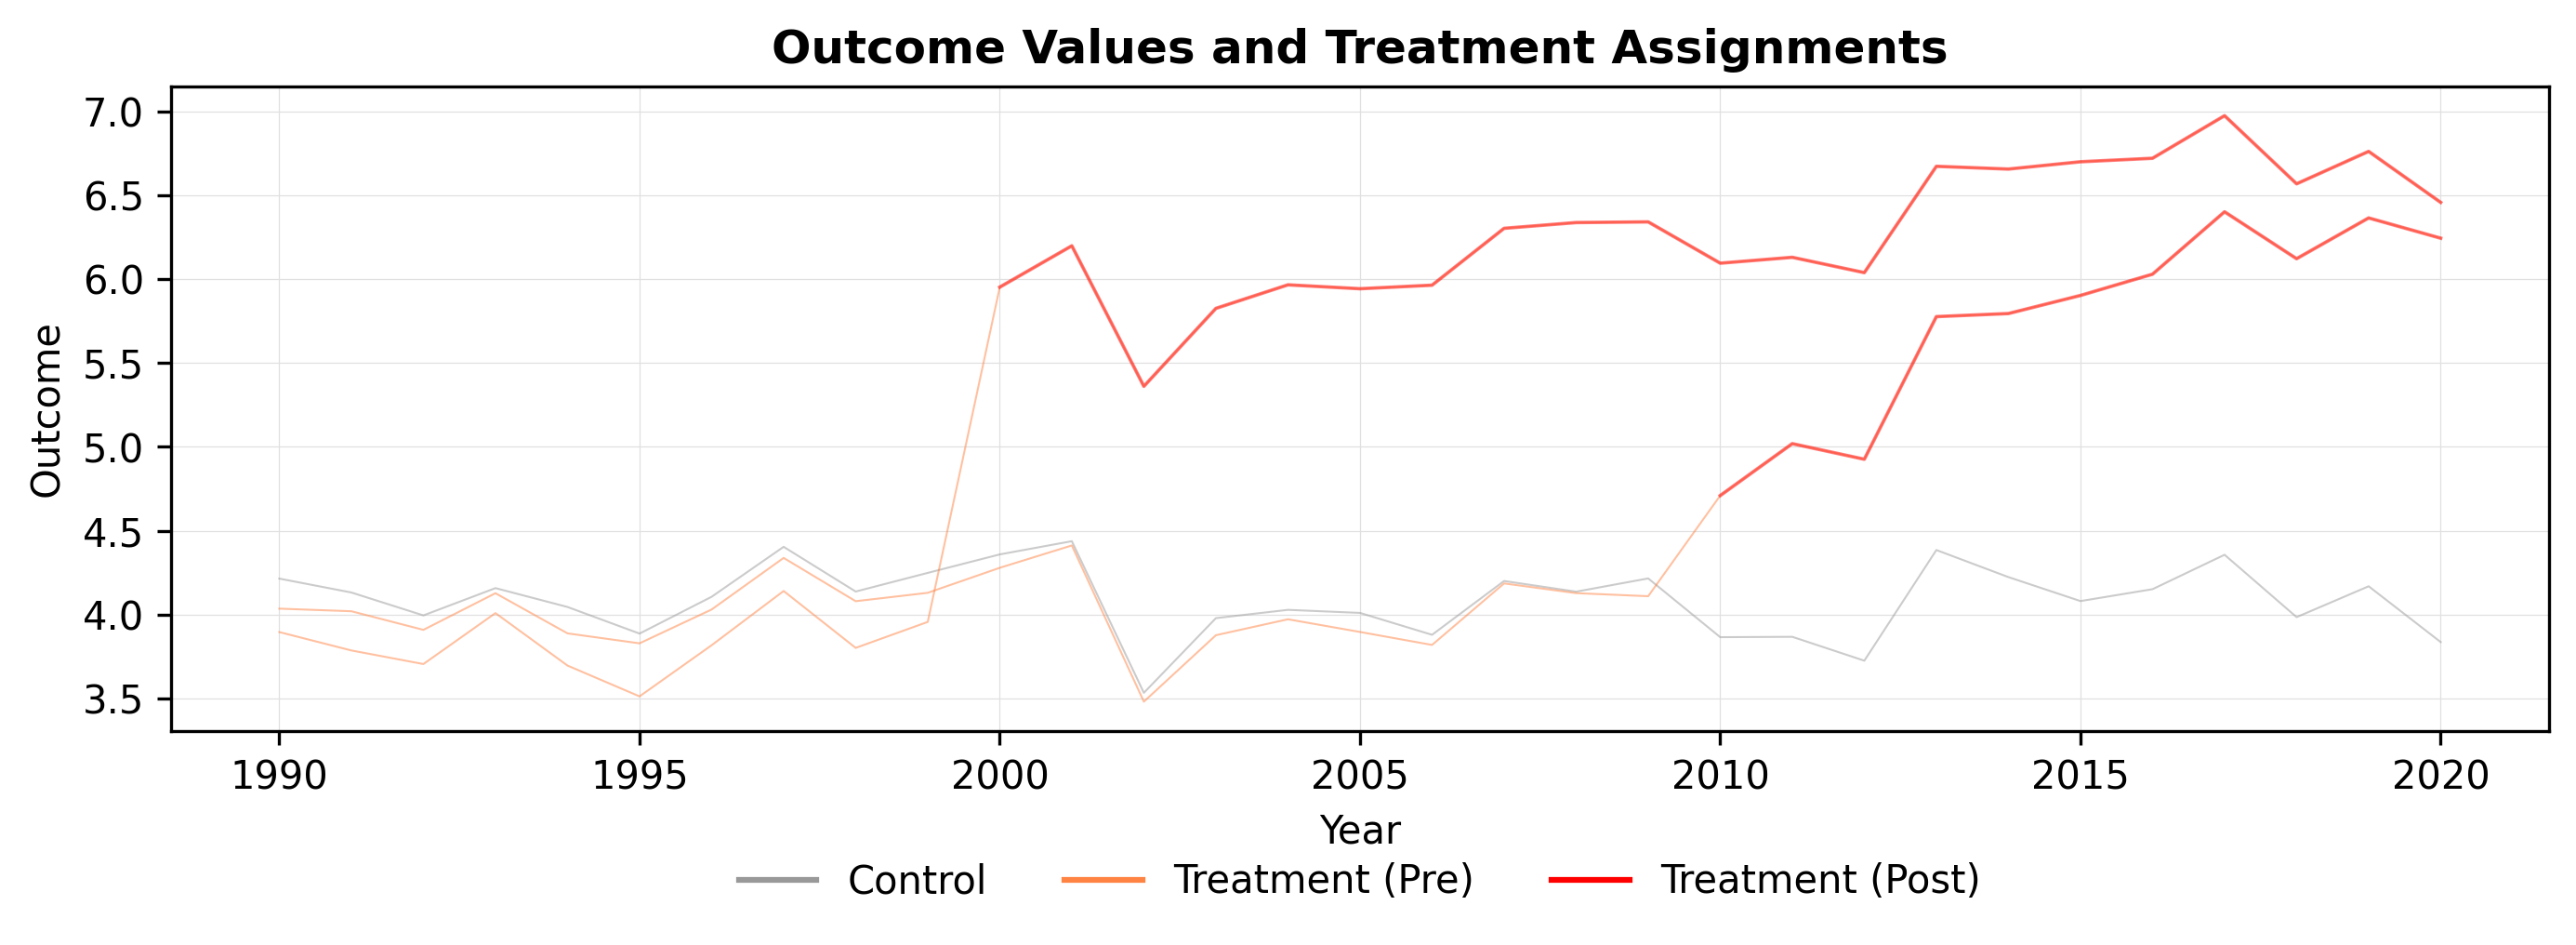

In [75]:
panelview(
    df_het,
    type = "outcome",
    outcome = "dep_var",
    unit="unit",
    time="year",
    treat="treat",
    ylab="Outcome",
    xlab="Year",
    title = "Outcome Values and Treatment Assignments",
    collapse_to_cohort = True,
    legend = True
)

To focus on specific units within your analysis, we can utilize `units_to_plot=[unit1, unit2, unit3, ...]` parameter. By setting this option, the function will generate plots exclusively for the selected units.

<Axes: title={'center': 'Outcome Values and Treatment Assignments'}, xlabel='Year', ylabel='Outcome'>

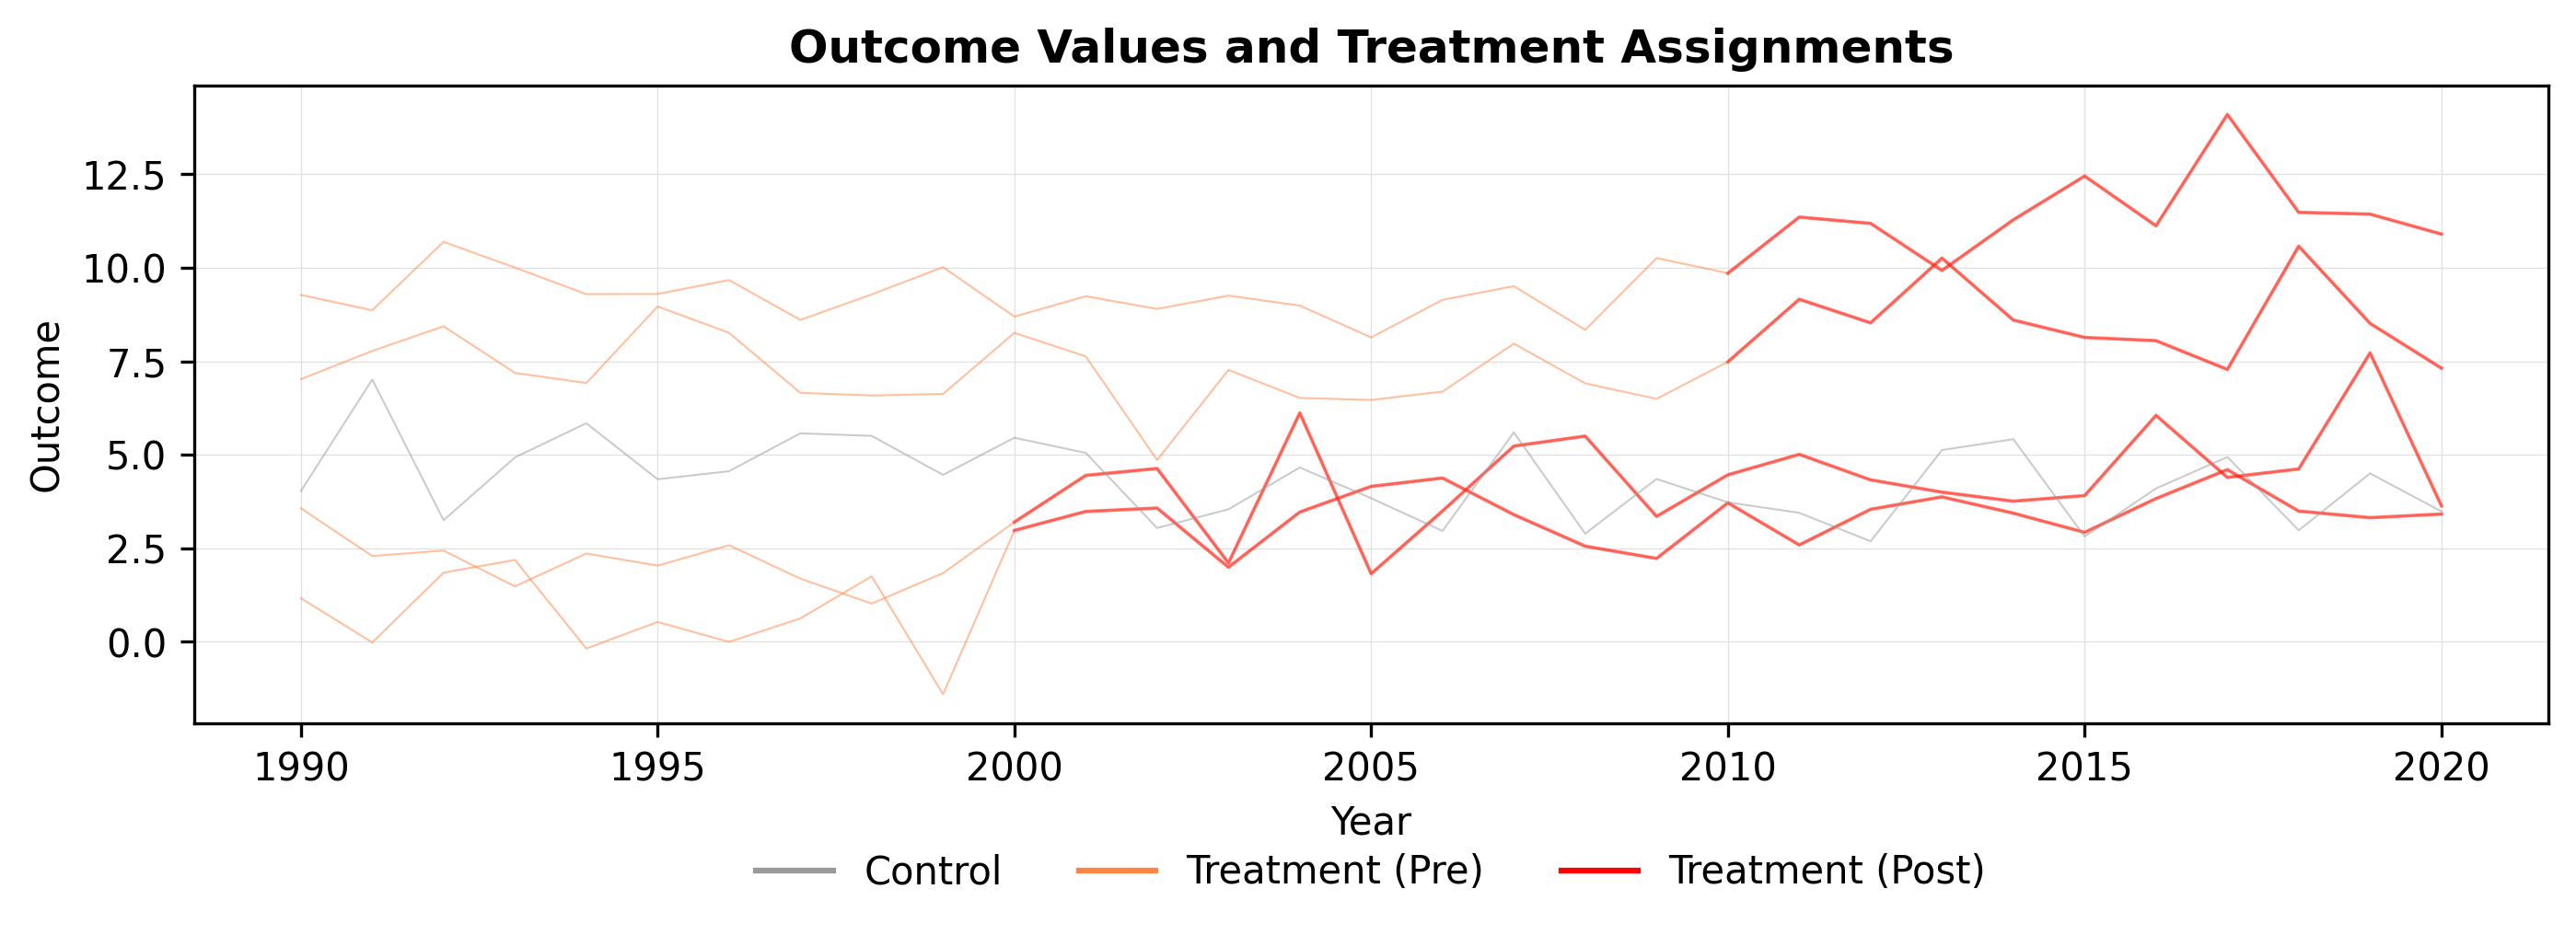

In [76]:
panelview(
    df_het,
    type = "outcome",
    outcome = "dep_var",
    unit="unit",
    time="year",
    treat="treat",
    ylab="Outcome",
    xlab="Year",
    title = "Outcome Values and Treatment Assignments",
    units_to_plot=[1, 2, 3, 4, 5],
    legend = True
)

### DiD Estimation via `feols()`, `did2s()` and `lpdid()`

We can estimate a simple two-way fixed effects DiD regression via `feols()`:

In [77]:
fit_twfe = pf.feols(
    "dep_var ~ i(rel_year, ref=-1.0) | state + year",
    df_het,
    vcov={"CRV1": "state"},
)

To do the same via Gardners 2-stage estimator, we employ the the `did2s()` function: 

In [78]:
fit_did2s = did2s(
    df_het,
    yname="dep_var",
    first_stage="~ 0 | state + year",
    second_stage="~i(rel_year,ref=-1.0)",
    treatment="treat",
    cluster="state",
)

Last, we can estimate the ATT for each time period via local projections by using the `lpdid()` function: 

In [79]:
fit_lpdid = lpdid(
    data=df_het,
    yname="dep_var",
    gname="g",
    tname="year",
    idname="unit",
    vcov={"CRV1": "state"},
    pre_window=-20,
    post_window=20,
    att=False,
)

Let's look at some results: 

In [80]:
figsize = [1200, 400]

In [82]:
fit_twfe.iplot(
    coord_flip=False,
    title="TWFE-Estimator",
    figsize=figsize,
    xintercept=18.5,
    yintercept=0,
    labels = rename_event_study_coefs(fit_twfe._coefnames), # rename coefficients
).show()

In [83]:
fit_did2s.iplot(
    coord_flip=False,
    title="DID2s-Estimator",
    figsize=figsize,
    xintercept=18.5,
    yintercept=0,
    labels = rename_event_study_coefs(fit_twfe._coefnames), # rename coefficients
).show()

In [84]:
fit_lpdid.iplot(
    coord_flip=False,
    title="Local-Projections-Estimator",
    figsize=figsize,
    yintercept=0,
    xintercept=18.5,
).show()

What if we are not interested in the ATT per treatment period, but in a pooled effects? 

In [85]:
fit_twfe = pf.feols(
    "dep_var ~ i(treat) | unit + year",
    df_het,
    vcov={"CRV1": "state"},
)

fit_did2s = did2s(
    df_het,
    yname="dep_var",
    first_stage="~ 0 | unit + year",
    second_stage="~i(treat)",
    treatment="treat",
    cluster="state",
)

fit_lpdid = lpdid(
    data=df_het,
    yname="dep_var",
    gname="g",
    tname="year",
    idname="unit",
    vcov={"CRV1": "state"},
    pre_window=-20,
    post_window=20,
    att=True,
)

In [86]:
fit_twfe.tidy()

,Estimate,Std. Error,t value,Pr(>|t|),2.5%,97.5%
Coefficient,,,,,,
C(treat)[T.True],1.98254,0.019331,102.55618,0.0,1.943439,2.021642


In [87]:
fit_did2s.tidy()

,Estimate,Std. Error,t value,Pr(>|t|),2.5%,97.5%
Coefficient,,,,,,
C(treat)[T.True],2.230481,0.024709,90.271496,0.0,2.182053,2.278909


In [88]:
fit_lpdid.tidy()

,Estimate,Std. Error,t value,Pr(>|t|),2.5%,97.5%,N
treat_diff,2.506746,0.071357,35.129648,0.0,2.362413,2.65108,5716.0
